# Ramsey-Cass-Koopmans model

Ramsey model from Chapter 2 of D. Romer's *Advanced Economics* looks as follows...

\begin{align}
    \dot{k}(t) =& k(t)^{\alpha} - c(t) - (g + n + \delta)k(t),\\
    k(0) =& k_0 \\
    \dot{c}(t) =& \Bigg[\frac{1}{\theta} \bigg[\alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g\bigg]\Bigg]c(t),\\
    lim_{t\rightarrow \infty} c(t) =& c^*
\end{align}

...where...

* Elasticity of output with respect to catpial: $0 < \alpha < 1$
* Coefficient of relative risk aversion: $0 < \theta$
* Discount rate: $0 < \rho$
* Breakeven investment: $0 < g + n + \delta$
* Convergent lifetime utility: $0 < \rho - n - (1 - \theta)g$

Note that we are assuming two things...

1. Cobb-Douglas production
2. Constant Relative Risk Aversion (CRRA) preferences



In [3]:
% matplotlib inline

In [4]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import seaborn as sn

import pycollocation


In [5]:
#define some  variables
t, k, c = sym.symbols("t, k, c")

In [6]:
#define some production parameters
alpha, delta = sym.symbols("alpha, delta")

#define growth rates
g, n = sym.symbols("g, n")

#define some preference parameters
theta, rho = sym.symbols("theta, rho")

In [7]:
#defube a production function
f = k**alpha
print f

k**alpha


In [8]:
#define a flow utility function
u = (c**(1 - theta) - 1) / (1 - theta)
print u

(c**(-theta + 1) - 1)/(-theta + 1)


In [9]:
#define the equation of motion for capital (per unit effective labor)
k_dot = f - c - (g + n + delta) * k
print k_dot

-c - k*(delta + g + n) + k**alpha


In [11]:
#define the Euler equation
c_dot = ((1 / theta) * (alpha * k**(alpha - 1) - delta - rho - theta * g))*c
print c_dot

c*(alpha*k**(alpha - 1) - delta - g*theta - rho)/theta


In [35]:
#create a dictionary representing the RHS of our model
rhs = {'k': k_dot, 'c': c_dot}
print rhs

{'k': -c - k*(delta + g + n) + k**alpha, 'c': c*(alpha*k**(alpha - 1) - delta - g*theta - rho)/theta}


In [36]:
#define the steady state value for capital (per unit effective labour)
k_star = (alpha / (delta + rho + theta * g)) **(1 / (1 - alpha))
print k_star

(alpha/(delta + g*theta + rho))**(1/(-alpha + 1))


In [37]:
#define the steady state value for consumption (per unit effective lavour)
c_star = k_star**alpha - (g + n + delta) * k_star
print c_star

-(alpha/(delta + g*theta + rho))**(1/(-alpha + 1))*(delta + g + n) + ((alpha/(delta + g*theta + rho))**(1/(-alpha + 1)))**alpha


In [65]:
#define some boundary conditions
k0 = 1.0

bcs = {'lower': [k - k0], 'upper': [c - c_star]}
print bcs

{'upper': [c + (alpha/(delta + g*theta + rho))**(1/(-alpha + 1))*(delta + g + n) - ((alpha/(delta + g*theta + rho))**(1/(-alpha + 1)))**alpha], 'lower': [k - 1.0]}


In [66]:
#finally we need to define some parameters...
params = {'alpha': 0.33, 'delta': 0.04, 'theta': 1.05, 'rho': 0.05, 'g': 0.02, 'n': 0.02}

Using pycollocation

In [67]:
model = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['k', 'c'], independent_var='t', rhs=rhs, boundary_conditions=bcs, params=params)

In [68]:
model.rhs

{'c': c*(alpha*k**(alpha - 1) - delta - g*theta - rho)/theta,
 'k': -c - k*(delta + g + n) + k**alpha}

In [69]:
solver = pycollocation.OrthogonalPolynomialSolver(model)

In [70]:
#numeric version of steady state capital
def numeric_k_star(alpha, delta, theta, rho, g, n):
    return (alpha / (delta + rho + theta * g))**(1 / (1 - alpha))

In [71]:
numeric_k_star(**params)

5.084580947867504

In [76]:
#define our domain of approximation
domain = [0.0, 100.0]

#initial guess for capital
N = 1000
ts = np.linspace(domain[0], domain[1], N)

ks = numeric_k_star(**params) - (numeric_k_star(**params) - k0) * np.exp(-ts)

initial_capital_polynomial = np.polynomial.Chebyshev.fit(ts, ks,35, domain)

#initial guess for consumption
cs = np.log(ks)
initial_consumption_polynomial = np.polynomial.Chebyshev.fit(ts, ks, 35, domain)


#create a dictionary of the coefs of our polynomials
initial_guess = {'k':initial_capital_polynomial.coef,
                 'c':initial_consumption_polynomial.coef}

In [73]:
solver.solve(kind="Chebyshev", 
             coefs_dict=initial_guess,
             domain=domain)

In [78]:
solver.result.x

array([  4.37225405e+00,   1.29407760e+00,  -9.72862387e-01,
         6.08921292e-01,  -3.18201558e-01,   1.37285311e-01,
        -4.62850602e-02,   9.22882158e-03,   2.25265029e-03,
        -4.07400457e-03,   3.21211999e-03,  -2.07493833e-03,
         1.24105453e-03,  -7.22117265e-04,   4.18592259e-04,
        -2.44435831e-04,   1.44396565e-04,  -8.63551433e-05,
         5.22449113e-05,  -3.19390959e-05,   1.97071578e-05,
        -1.22605018e-05,   7.68428916e-06,  -4.84844392e-06,
         3.07792569e-06,  -1.96514557e-06,   1.26163055e-06,
        -8.14606070e-07,   5.29424467e-07,  -3.47071441e-07,
         2.30580740e-07,  -1.56776432e-07,   1.10978890e-07,
        -8.39515496e-08,   4.59631211e-08,  -9.06485055e-09,
         1.17873943e+00,   2.28498625e-01,  -1.76366595e-01,
         1.16303877e-01,  -6.68076608e-02,   3.42707361e-02,
        -1.62089828e-02,   7.36702585e-03,  -3.37782840e-03,
         1.63268450e-03,  -8.50106910e-04,   4.74261607e-04,
        -2.78167064e-04,

In [74]:
#now lets plot the solution
visualizer = pycollocation.Visualizer(solver)

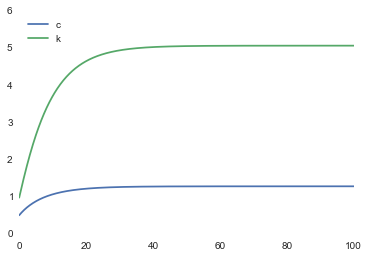

In [75]:
visualizer.interpolation_knots = np.linspace(0, 100, 1000)
visualizer.solution.plot()
plt.show()

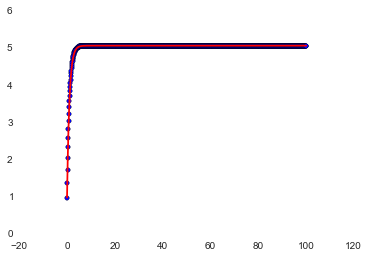

In [77]:
plt.scatter(ts, ks)
plt.plot(ts, initial_capital_polynomial(ts), 'r-')
plt.show()

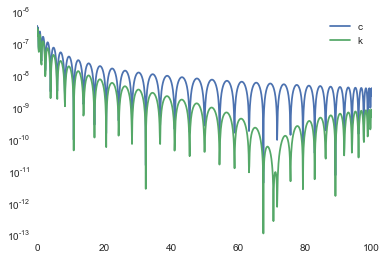

In [79]:
#plot the normalized residuals(ther should be small everywhere)
visualizer.normalized_residuals.plot(logy=True)
plt.show()